In [1]:
import numpy as np
import scipy
from scipy import ndimage
import h5py, os
import glob
import torch
import torch.fft as torch_fft
# from pytorch_nufft.nufft import nufft,nufft_adjoint
import matplotlib.pyplot as plt

# Dataloader

In [2]:
import h5py, os
import numpy as np
import sigpy as sp
import torch
import torch.fft as torch_fft
from torch.utils.data import Dataset
import scipy
from scipy import ndimage

def adjoint_op(ksp,mask,maps):
        # Multiply input with mask and pad
        mask_adj_ext = mask
        ksp_padded  = ksp * mask_adj_ext

        # Get image representation of ksp
        img_ksp = np.fft.fftshift(ksp_padded,axes=(- 2, - 1))
        img_ksp = np.fft.ifft2(img_ksp, axes=(- 2, - 1),norm='ortho')
        img_ksp = np.fft.ifftshift(img_ksp,axes=(- 2, - 1))

        # Pointwise complex multiply with complex conjugate maps
        mult_result = img_ksp * np.conj(maps)

        # Sum on coil axis
        x_adj = np.sum(mult_result, axis=0)

        return x_adj

def forward_op(img_kernel, maps, mask):
        # Pointwise complex multiply with maps
        mult_result = img_kernel * maps

        # Convert back to k-space
        result = np.fft.ifftshift(mult_result, axes=(-2, -1))
        result = np.fft.fft2(result, axes=(-2, -1), norm='ortho')
        result = np.fft.fftshift(result, axes=(-2, -1))

        # Multiply with mask
        result = result * mask

        return result
    
def translate(input, delta_x, delta_y):
    output = np.roll(input, delta_x, axis = 1)
    output = np.roll(output, delta_y, axis = 0)
    return output

class MotionCorrupt(Dataset):
    def __init__(self, sample_list, maps_list, num_slices,
                 center_slice, num_shots):
        self.sample_list  = sample_list
        self.num_slices   = num_slices
        self.center_slice = center_slice
        self.maps         = maps_list # Pre-estimated sensitivity maps
        self.num_shots    = num_shots

    def __len__(self):
        return len(self.sample_list) * self.num_slices

    def __getitem__(self, idx):

        # Convert to numerical
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Separate slice and sample
        sample_idx = idx // self.num_slices
        slice_idx  = self.center_slice + \
            np.mod(idx, self.num_slices) - self.num_slices // 2

        # Load MRI image
        with h5py.File(self.sample_list[sample_idx], 'r') as contents:
            # Get k-space for specific slice
            k_image = np.asarray(contents['kspace'][slice_idx])
            ref_rss = np.asarray(contents['reconstruction_rss'][slice_idx])

        # If desired, load external sensitivity maps
        if not self.maps is None:
            with h5py.File(self.maps[sample_idx], 'r') as contents:
                # Get sensitivity maps for specific slice
                s_maps      = np.asarray(contents['s_maps'][slice_idx])#was map_idx

        
        
        gt_img = adjoint_op(k_image, np.ones(1), s_maps)

        lines_per_shot = int(np.ceil(k_image.shape[-1]/self.num_shots)) #how many lines should be taken for each motion state 
        
        #generate motion corrupted image
        for shot in range(self.num_shots):
            angle = np.random.uniform(low = -15.0, high = 15.0)
            delta_x = int(np.ceil(np.random.uniform(low = -50.0, high = 50.0)))
            delta_y = int(np.ceil(np.random.uniform(low = -50.0, high = 50.0)))
            motion_img = ndimage.rotate(input=gt_img, angle=angle, 
                                        axes=(1, 0), reshape=False, output=None, order=3,
                                        mode='constant', cval=0.0, prefilter=True) #apply rotation
            
            motion_img = translate(input = motion_img, delta_x = delta_x, delta_y = delta_y)
           
            motion_ksp = np.fft.fftshift(np.fft.fft2(motion_img, norm = 'ortho'))
            
            start_line = shot*lines_per_shot
            end_line   = (shot+1)*lines_per_shot
            
            if shot == 0:
                lines = motion_ksp[:,start_line:end_line]
                ksp_motion_corrupt = lines
            if shot > 0:
                if shot<(self.num_shots-1):
                    lines = motion_ksp[:,start_line:end_line] 
                else: 
                    lines = motion_ksp[:,start_line:]
                    
                ksp_motion_corrupt = np.append(ksp_motion_corrupt, lines,axis=1)
                
            
        img_motion_corrupt = np.fft.ifft2(ksp_motion_corrupt)
        scale_gt = np.max(abs(gt_img))
        scale_motion = np.max(abs(img_motion_corrupt))
        
        img_motion_corrupt = img_motion_corrupt/scale_motion
        gt_img = gt_img/scale_gt
        data_range = np.max(abs(gt_img))
        sample = {'idx': idx,
                  'ksp_motion_corrupt': ksp_motion_corrupt.astype(np.complex64),
                  'img_motion_corrupt': img_motion_corrupt.astype(np.complex64),
                  'ksp_gt': k_image.astype(np.complex64),
                  'img_gt': gt_img.astype(np.complex64),
                  'data_range': data_range
#                   'acs_image': acs_image.astype(np.float32),
#                   'norm_const': norm_const.astype(np.float32)
                 }

        return sample

# Training

In [3]:
from torch.utils.data import DataLoader
os.chdir('/home/sidharth/sid_notebooks/motion_correction')
from unet_branch import OldUnetModel
from losses import SSIMLoss, MCLoss, NMSELoss, NRMSELoss
from torch.optim import Adam
%matplotlib inline
core_dir_1    = '/csiNAS/mridata/fastmri_brain/brain_multicoil_train/multicoil_train'
maps_dir_1    = '/csiNAS/mridata/fastmri_brain/multicoil_train_espiritWc0_mvue_ALL'

train_files_1 = sorted(glob.glob(core_dir_1 + '/*.h5'))
train_maps_1  = sorted(glob.glob(maps_dir_1 + '/*.h5'))
dataset = MotionCorrupt(sample_list = train_files_1, maps_list=train_maps_1, num_slices=1, center_slice = 5, num_shots = 11)
train_loader  = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0, drop_last=True)

In [8]:
print(torch.__version__)
print(scipy.__version__)

1.9.0
1.5.2


In [4]:
num_epochs = 100

model      = OldUnetModel(in_chans = 2 , out_chans = 2, chans = 32,
                            num_pool_layers = 4, drop_prob = 0.0)
model      = model.cuda()

optimizer  = Adam(model.parameters(), lr=1e-2)


ssim       = SSIMLoss().cuda()
nrmse_loss = NRMSELoss()


running_training  = 0.0
running_nrmse     = 0.0
running_ssim      = -1.0

for epoch_idx in range(num_epochs):
    for sample_idx, sample in enumerate(train_loader):
        
        # Move to CUDA
        for key in sample.keys():
            try:
                sample[key] = sample[key].cuda()
            except:
                pass
        
        inp_img        = torch.view_as_real(sample['img_motion_corrupt']).permute(0,3,1,2)
        model_out      = model(input = inp_img).permute(0,2,3,1)
        out            = torch.view_as_complex(model_out.contiguous())
        est_img_rss    = torch.abs(out)
        
        gt_img         = torch.abs(sample['img_gt'])
        data_range     = sample['data_range']
        ssim_loss      = ssim(est_img_rss[:,None], gt_img[:,None], data_range)
        
        loss = ssim_loss
#         print("input max:", torch.max(abs(sample['img_motion_corrupt'])))
#         print("est_img max:", torch.max(est_img_rss))
#         print("gt_img max:", torch.max(gt_img))
#         print("data range:",data_range)
        # Other Loss for tracking
        with torch.no_grad():
            nrmse      = nrmse_loss(gt_img,est_img_rss)
        
        
        running_ssim     = 0.99 * running_ssim + 0.01 * (1-ssim_loss.item()) if running_ssim > -1. else (1-ssim_loss.item())
        running_nrmse    = 0.99 * running_nrmse + 0.01 * nrmse.item() if running_nrmse > 0. else nrmse.item()
        running_training = 0.99 * running_training + 0.01 * loss.item() if running_training > 0. else loss.item()
#         if (epoch_idx ==0) and (sample_idx == 0):
#             plt.figure()
#             plt.subplot(1,3,1)
#             plt.imshow(abs(gt_img[0,...].cpu()))
#             plt.subplot(1,3,2)
#             plt.imshow(abs(est_img_rss[0,...].detach().cpu()))
#             plt.subplot(1,3,3)
#             plt.imshow(abs(sample['img_motion_corrupt'][0,...].cpu()))
        # Backprop
        optimizer.zero_grad()
        ssim_loss.backward()
        # torch.nn.utils.clip_grad_norm(model.parameters(), hparams.grad_clip)
        optimizer.step()
                
        print('Epoch %d ,Step %d, Batch loss %.4f. Avg. SSIM %.4f, Avg. NRMSE %.4f' % (
                    epoch_idx, sample_idx, loss.item(), running_ssim, running_nrmse))


TypeError: Complex type not supported

# Validation

In [ ]:
from torch.utils.data import DataLoader
from unet_branch import OldUnetModel
from losses import SSIMLoss, MCLoss, NMSELoss, NRMSELoss
from torch.optim import Adam
%matplotlib inline
core_dir_1    = '/csiNAS/mridata/fastmri_brain/brain_multicoil_train/multicoil_train'
maps_dir_1    = '/csiNAS/mridata/fastmri_brain/multicoil_train_espiritWc0_mvue_ALL'

train_files_1 = sorted(glob.glob(core_dir_1 + '/*.h5'))
train_maps_1  = sorted(glob.glob(maps_dir_1 + '/*.h5'))
dataset = MotionCorrupt(sample_list = train_files_1, maps_list=train_maps_1, num_slices=1, center_slice = 5, num_shots = 11)
train_loader  = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0, drop_last=True)
iterator = iter(train_loader)

In [39]:
model      = OldUnetModel(in_chans = 2 , out_chans = 2, chans = 32,
                            num_pool_layers = 4, drop_prob = 0.0)
model      = model.cuda()

local_dir = 'Results/seed1500'
saved_model = torch.load(local_dir + '/epoch'+str(5)+'_last_weights.pt')
model.load_state_dict(saved_model['model_state_dict'])

ssim       = SSIMLoss().cuda()
nrmse_loss = NRMSELoss()

tensor(0.4130, device='cuda:0', dtype=torch.float64)
tensor(0.3161, device='cuda:0', dtype=torch.float64, grad_fn=<RsubBackward1>)


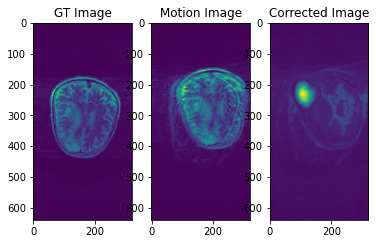

In [42]:
sample = next(iterator)
for key in sample.keys():
    try:
        sample[key] = sample[key].cuda()
    except:
        pass

inp_img        = torch.view_as_real(sample['img_motion_corrupt']).permute(0,3,1,2)
model_out      = model(input = inp_img).permute(0,2,3,1)
out            = torch.view_as_complex(model_out.contiguous())
est_img_rss    = torch.abs(out)

gt_img         = torch.abs(sample['img_gt'])
data_range     = sample['data_range']
ssim_loss      = ssim(est_img_rss[:,None], gt_img[:,None], data_range)
ssim_loss_motion      = ssim(abs(sample['img_motion_corrupt'])[:,None], gt_img[:,None], data_range)

loss = ssim_loss
print(ssim_loss_motion)
print(ssim_loss)
plt.figure()
plt.subplot(1,3,1)
plt.title('GT Image')
plt.imshow(gt_img[0,...].cpu())
plt.subplot(1,3,2)
plt.title('Motion Image')
plt.imshow(abs(sample['img_motion_corrupt'])[0,...].cpu())
plt.subplot(1,3,3)
plt.title('Corrected Image')
plt.imshow(est_img_rss[0,...].cpu().detach().numpy())

In [ ]:
#create deterministic motion that is the same